# Assignment 3

Welcome to the assignment for week 3.

## Task 3: Hough Transform

There are two datasets available: "images/eye_tracking" and "images/lane_detection". Implement the classical Hough Transform for lines (lane detection) and circles (eye tracking) as shown in the lecture. Use any Canny Edge Detector implementation to produce edge images.

To pass this assignment, we want you to solve (Task 3.1 OR Task 3.2) AND Task 3.3. The BONUS Task 3.4 is optional as well as one of the first 2 tasks. If you are confused, just solve all of them!

In [2]:
# imports
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, feature, color, filters
from matplotlib.patches import Circle
from tqdm.notebook import tqdm
from skimage.draw import line
import math
import numpy as np

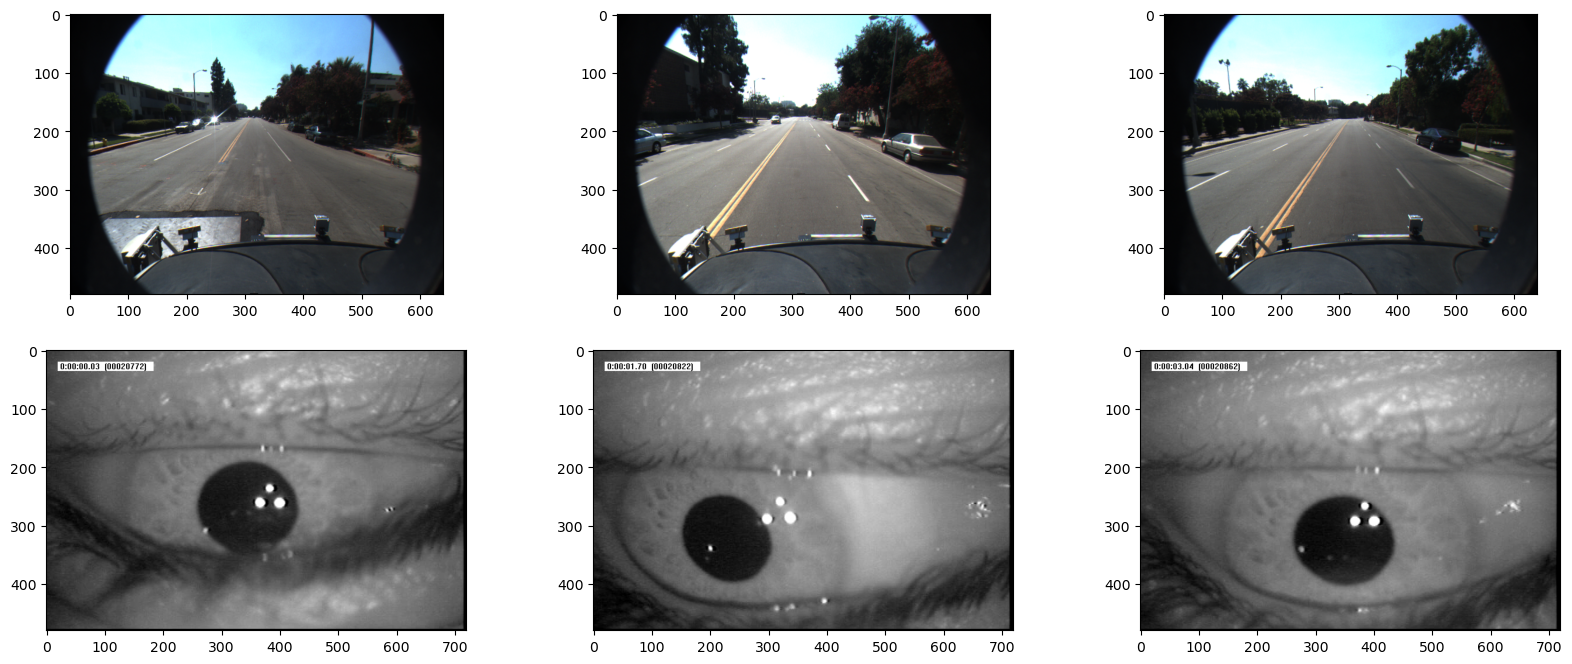

In [3]:
# Plotting some samples
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')
eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(20, 8))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)

ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)
ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

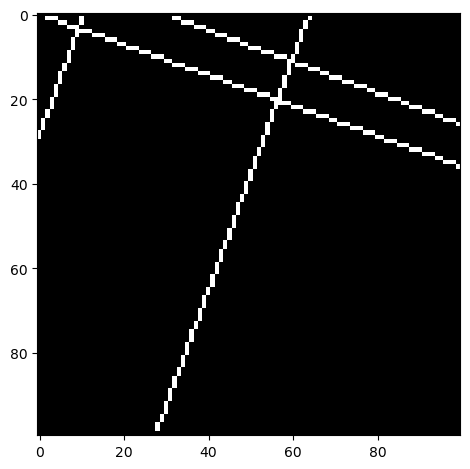

In [4]:
def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 60)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

### Task 3.1: Detecting lanes

Put your Lane Detection solution here.

* Use your implementation of the Hough Transform to find the 10 strongest lines in one lane_detection image
* Display your result set (draw those lines on the image) (**RESULT**)
* Can you improve the performance by limiting the space of solutions?

In [5]:
#my implementation of canny filter

def round_to_direction(direction, base = np.pi/4):
    return np.round(direction/(np.pi/4))*np.pi/4

def threshold(image, lim):
    return(np.where(image > lim, 0.5, 0))

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def conv2d(image, kernel, mode = 'constant'):
    kernel = np.array(kernel)
    if np.sum(kernel) != 0 : kernel = kernel/np.sum(kernel) # kernel normalization
    kernel_size = kernel.shape[0]
    kernel_hw = kernel_size//2
    padded = np.pad(image, kernel_hw, mode = mode)

    convolved = np.zeros(image.shape)

    i_width, i_height = image.shape[0], image.shape[1]

    for y in range(i_height):
        for x in range(i_width):
            cur_window = padded[x:x+2*kernel_hw+1, y:y+2*kernel_hw+1] * kernel
            convolved[x, y] = np.sum(cur_window)


    return convolved


def non_maximum_suppression(image):

    gaussian_kernel = gkern(l = 5, sig = 3)
    sobel_x = [[-1, 0, 1], [-2, 0, 2], [-1, 0,1]]
    sobel_y = np.rot90(sobel_x)

    smoothed_image = conv2d(image, gaussian_kernel, mode = 'edge')

    x_direction = conv2d(smoothed_image, sobel_x, mode = 'edge')
    y_direction = conv2d(smoothed_image, sobel_y, mode = 'edge')

    g_magnitude = np.sqrt(x_direction**2+y_direction**2)
    g_direction = np.arctan2(y_direction, x_direction)

    rounded_direction = round_to_direction(g_direction, np.pi/4)

    nms = np.full_like(g_magnitude, 0)
    padded_magnitude = np.pad(g_magnitude, 1, mode = 'constant', constant_values=0)

    image_width, image_length = np.shape(image)[0], np.shape(image)[1]

    for i in range(image_width):
        for j in range(image_length):
            if abs(rounded_direction[i][j]) - np.pi < 0.001 or abs(rounded_direction[i][j]) < 0.001:
                if (padded_magnitude[i+1][j+1] > padded_magnitude[i+1][j]) and (padded_magnitude[i+1][j+1] > padded_magnitude[i+1][j+2]):
                    nms[i][j] = g_magnitude[i][j]
            if (rounded_direction[i][j] - np.pi/4 < 0.001) or (rounded_direction[i][j] + 3*np.pi/4 < 0.001):
                if (padded_magnitude[i+1][j+1] > padded_magnitude[i][j]) and (padded_magnitude[i+1][j+1] > padded_magnitude[i+2][j+2]):
                    nms[i][j] = g_magnitude[i][j]
            if (rounded_direction[i][j] - np.pi/2 < 0.001) or (rounded_direction[i][j] + np.pi/2 < 0.001):
                if (padded_magnitude[i+1][j+1] > padded_magnitude[i][j+1]) and (padded_magnitude[i+1][j+1] > padded_magnitude[i+2][j+1]):
                    nms[i][j] = g_magnitude[i][j]
            if (rounded_direction[i][j] - 3*np.pi/4 < 0.001) or (rounded_direction[i][j] + np.pi/4 < 0.001):
                if (padded_magnitude[i+1][j+1] > padded_magnitude[i][j]) and (padded_magnitude[i+1][j+1] > padded_magnitude[i+2][j+2]):
                    nms[i][j] = g_magnitude[i][j]
    
    return nms, g_magnitude

def edge_tracing(nms, low, high):
    nms, g_magnitude = nms
    strong_edges = np.where(nms > np.max(g_magnitude)*high, 1, 0)
    weak_edges = np.where(nms > np.max(g_magnitude)*low, 1, 0) - strong_edges
    
    edges = strong_edges

    iu, iv = np.shape(nms)

    for u in range(1, iu-1):
        for v in range(1, iv-1):
            if weak_edges[u][v]:
                if np.max(strong_edges[u-1:u+2,v-1:v+2]):
                    edges[u][v] = 1
    
    return edges

def canny_filter(image, low = 0.05, high = 0.1):
    nms = non_maximum_suppression(image)
    edges = edge_tracing(nms, low, high)
    return edges

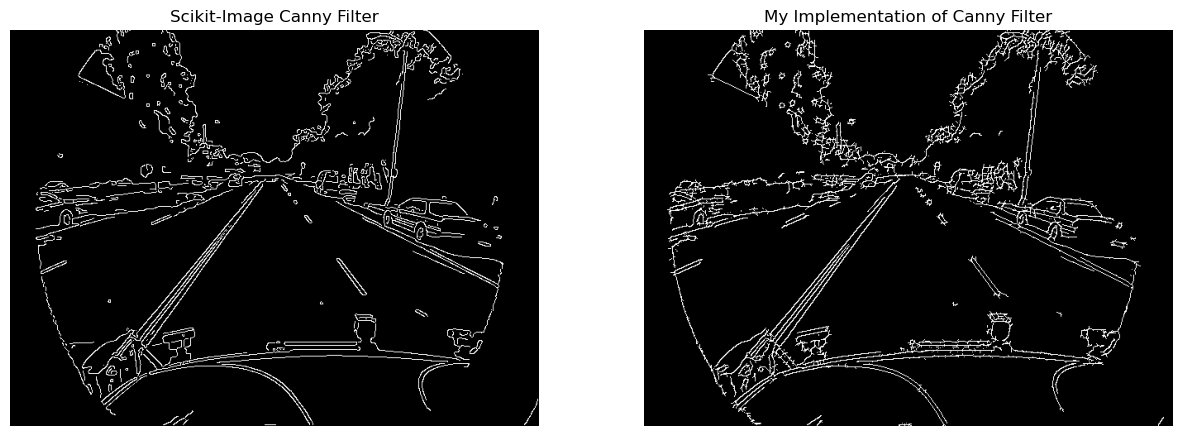

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

lane2bw = color.rgb2gray(lane2)

edges_canny = feature.canny(lane2bw)

ax[0].imshow(edges_canny, cmap='gray')
ax[0].set_title('Scikit-Image Canny Filter')
ax[0].set_axis_off()

edges_mycanny = canny_filter(lane2bw)

ax[1].imshow(edges_mycanny, cmap='gray')
ax[1].set_title('My Implementation of Canny Filter')
ax[1].set_axis_off()

In [16]:
edges = feature.canny(lane2bw)
angles = np.linspace(-np.pi / 2, np.pi / 2, 40, endpoint=False)

In [ ]:
def houghline(edges):

    iv, iu = np.shape(edges)
    angles = np.linspace(-np.pi / 2, np.pi / 2, 40, endpoint=False)
    
    r_max = int(np.ceil(np.sqrt(iu**2 + iv**2)))
    rhos = np.linspace(-r_max, r_max, r_max * 2)

    sin_t, cos_t = np.sin(angles), np.cos(angles)

    print(type(r_max), type(len(angles)))

    accumulator = np.zeros((2 * r_max, len(angles)), dtype=np.uint64)
    
    print(np.shape(accumulator))

    for v in range(iv):
        for u in range(iu):
            if edges[v, u]:
                for count, angle in enumerate(angles):
                    rho = round(u * cos_t[count] + v * sin_t[count]) + r_max
                    accumulator[int(rho), count] += 1

    
    return accumulator, angles, rhos

def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    #return list(zip(*np.unravel_index(indices, ary.shape)))
    return np.unravel_index(indices, ary.shape)


def houghline_peaks(hough, num_peaks):
    accumulator, angles, rhos = hough
    indices = largest_indices(accumulator, num_peaks)
    rhos = rhos[indices[0]]
    angles = angles[indices[1]]
    return rhos, angles

In [104]:
edges = feature.canny(lane2bw)
hough = houghline(edges)

<class 'int'> <class 'int'>
(1600, 40)


<class 'int'> <class 'int'>
(1600, 40)


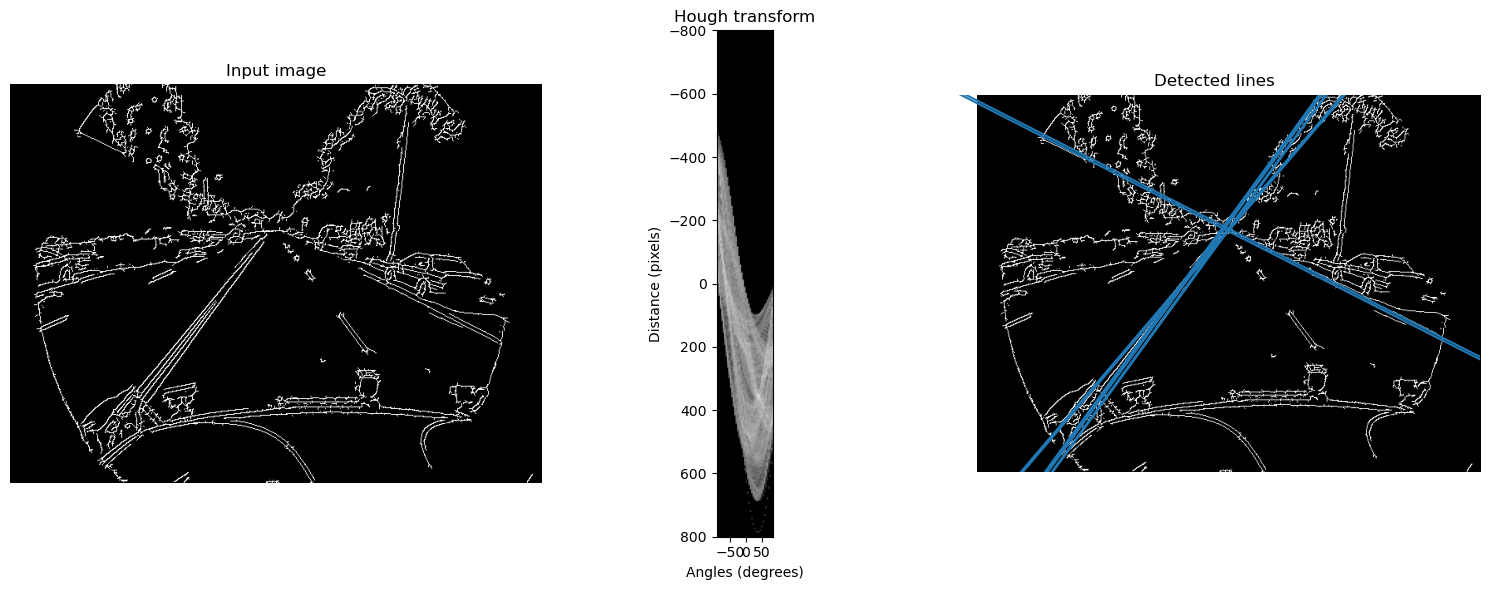

In [173]:
edges = canny_filter(lane2bw)

angles = np.linspace(-np.pi / 2, np.pi / 2, 40, endpoint=False)


h, theta, d = houghline(edges)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(edges, cmap = 'grey')
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step,
    d[0] - d_step,
]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap = 'grey', aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(edges, cmap = 'grey')
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for  dist, angle in zip(*houghline_peaks(hough, 10)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi / 2))

plt.tight_layout()
plt.show()

### Task 3.2: Eye Tracker

Put your Eye Tracker solution here.

* Use your implementation of the Hough Transform to find the 10 strongest circles in one eye_tracking sample image
* Display your result set (draw those circles on the image) (**RESULT**)
* Can you improve the performance by limiting the space of solutions?

In [9]:
image = color.rgb2gray(eye1)

In [10]:
np.shape(image)

(480, 720)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


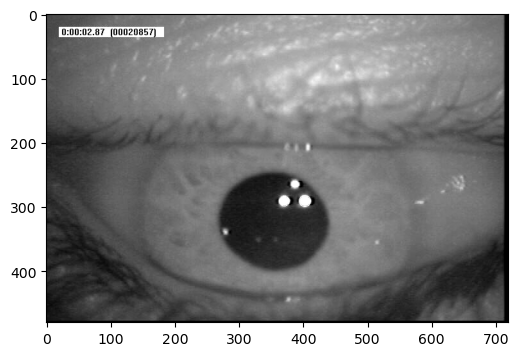

In [11]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

# Load picture and detect edges
eye4 = io.imread('images/eye_tracking/0085.jpeg')
image = color.rgb2gray(eye4)
edges = feature.canny(image, sigma=3)

# Detect two radii
hough_radii = np.arange(1, 500, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()


In [12]:
accums

array([0.875     , 0.79166667, 0.75      ])

### Task 3.3: Generalized Hough Transform

* Implement the Generalized Hough Transform as described in the lecture for localizing a given template
* Find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

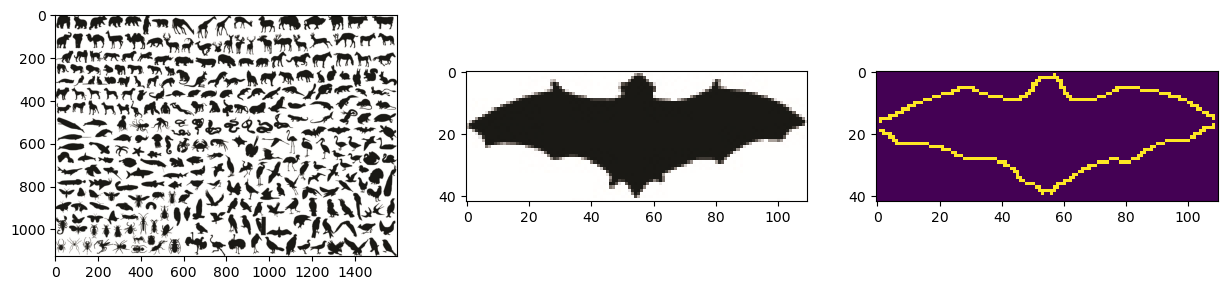

In [13]:
animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

In [14]:
# code here

### Task 3.4 (BONUS) 
* Implement an extended version of the GHT that find scaled and rotated variants of the template
* Find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.jpg")
* Note that you can binarize your italy template by using a simple color lookup
* Draw the location of italy on the map and print its scale and rotation (**BONUS**)

In [15]:
# code here

## Congratz, you made it! :)